# 베이즈 회귀
베이즈 통계는 오늘날 실증적 금융공학의 초석이다. 

## PyMC3
PyMC3는 베이즈 통계를 기술적으로 구현할 수 있는 강력한 고성능 라이브러리이다.

In [1]:
import warnings
warnings.simplefilter('ignore')
import pymc3 as pm
import numpy as np
np.random.seed(1000)
import matplotlib.pyplot as plt
%matplotlib inline

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## 기초 예제

In [5]:
# 일직선 상에 잡음이 있는 자료의 예
x = np.linspace(0,10,500)
y = 4 +2*x + np.random.standard_normal(len(x))*2

In [6]:
reg = np.polyfit(x, y, 1)

Text(0, 0.5, 'y')

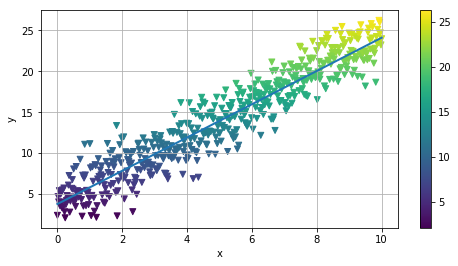

In [7]:
plt.figure(figsize=(8,4))
plt.scatter(x, y, c=y, marker='v')
plt.plot(x, reg[1] + reg[0]*x, lw=2.0)
plt.colorbar()
plt.grid(True)
plt.xlabel('x')
plt.ylabel('y')

In [8]:
reg

array([2.03384161, 3.77649234])

베이즈 회귀분석의 중요한 방법 중의 하나는 마코프 체인 몬테카를로 방법이다. MCMC는 좀 더 구조적이고 자동화되어 있을 뿐 그 원리 상으로 상자에서 공을 꺼내는 앞의 예제와 다를바 없다.  
몬테카를로 샘플링을 위한 세 가지 다른 함수가 제공된다.  
* find_MAP 함수는 사후 확률을 최대화하는 국지점을 계산하여 샘플링 알고리즘의 시작점을 찾는다.  
* NUTS 함수는 사전 확률에 따른 MCMC 샘플링 알고리즘을 구현한다.  
* sample 함수는 find_MAP에서 주어진 초깃값과 NUTS 알고리즘에서 구한 최적 구간 크기를 사용하여 샘플을 생성한다.

In [12]:
# 이 함수들은 PyMC3 모형 객체에 포함되어 있으므로 다음과 같이 with 문장으로 실행할 수 있다.
with pm.Model() as model:
    # 사전 확률 정의
    alpha = pm.Normal('alpha',mu=0,sd=20)
    beta = pm.Normal('beta',mu=0,sd=20)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    
    # 선형 회귀선 정의
    y_est = alpha + beta*x
    
    # 우도 정의
    likelihood = pm.Normal('y', mu=y_est, sd=sigma, observed=y)
    
    # 추정 과정
    start = pm.find_MAP() # 최적화를 사용하여 시작값 추정
    step = pm.NUTS() # MCMC 샘플링 알고리즘 인스턴스 생성 NUTS는 스테이트 자동 설정
    trace = pm.sample(100, step, start=start, progressbar = False) # NUTS 샘플링을 사용한 100개의 사후 샘플 생성

logp = -1,068.5, ||grad|| = 60.625: 100%|██████████████████████████████████████████████| 28/28 [00:03<00:00,  8.82it/s]
Only 100 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


In [13]:
trace[0]

{'alpha': 3.872390954677189,
 'beta': 2.0232889996953416,
 'sigma_interval__': -1.3807623221643985,
 'sigma': 2.0088659537585354}

<Figure size 576x576 with 0 Axes>

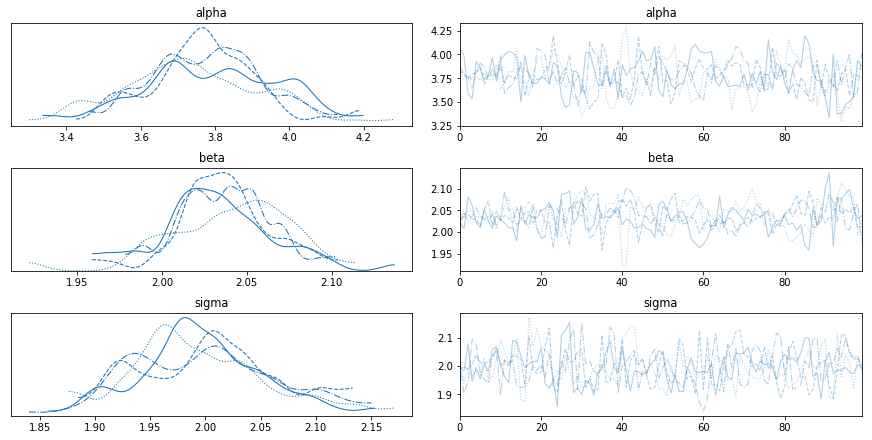

<Figure size 576x576 with 0 Axes>

In [14]:
fig = pm.traceplot(trace, lines={'alpha':4 , 'beta':2, 'sigma':2})
plt.figure(figsize=(8,8))

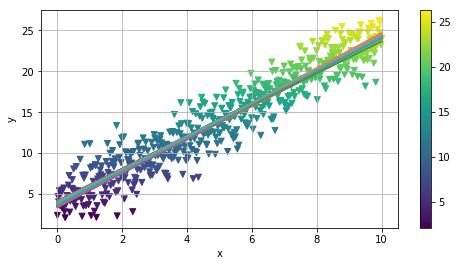

In [15]:
plt.figure(figsize=(8,4))
plt.scatter(x, y, c=y, marker='v')
plt.colorbar()
plt.grid(True)
plt.xlabel('x')
plt.ylabel('y')
for i in range(len(trace)):
    plt.plot(x, trace['alpha'][i] + trace['beta'][i] * x)

## 현실 자료 적용

In [2]:
import pandas as pd
import pandas_datareader.data as web
import datetime as dt

In [3]:
a = dt.datetime(2018, 1, 1)
b = dt.datetime(2020, 1, 1)

In [4]:
# 금 원자재와 금광 회사 주식의 페어 트레이딩 전략
symbols = ['GLD','GDX']

In [5]:
data = pd.DataFrame()
for sym in symbols:
    data[sym] = web.DataReader(sym, 'yahoo',a,b)['Close']
data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 503 entries, 2018-01-02 to 2019-12-31
Data columns (total 2 columns):
GLD    503 non-null float64
GDX    503 non-null float64
dtypes: float64(2)
memory usage: 11.8 KB


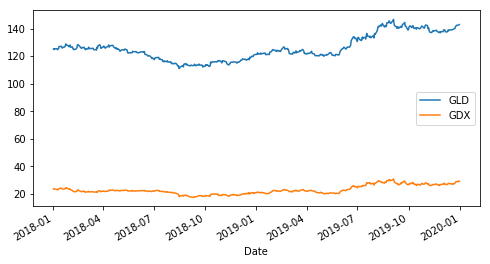

In [6]:
data.plot(figsize=(8,4))

In [7]:
data.iloc[-1]/data.iloc[0] -1

GLD    0.141830
GDX    0.229219
dtype: float64

In [8]:
data.corr()

,GLD,GDX
GLD,1.00000,0.96531
GDX,0.96531,1.00000


In [9]:
import matplotlib as mpl
mpl_dates = mpl.dates.date2num(data.index)
mpl_dates

array([736696., 736697., 736698., 736699., 736702., 736703., 736704.,
       736705., 736706., 736710., 736711., 736712., 736713., 736716.,
       736717., 736718., 736719., 736720., 736723., 736724., 736725.,
       736726., 736727., 736730., 736731., 736732., 736733., 736734.,
       736737., 736738., 736739., 736740., 736741., 736745., 736746.,
       736747., 736748., 736751., 736752., 736753., 736754., 736755.,
       736758., 736759., 736760., 736761., 736762., 736765., 736766.,
       736767., 736768., 736769., 736772., 736773., 736774., 736775.,
       736776., 736779., 736780., 736781., 736782., 736786., 736787.,
       736788., 736789., 736790., 736793., 736794., 736795., 736796.,
       736797., 736800., 736801., 736802., 736803., 736804., 736807.,
       736808., 736809., 736810., 736811., 736814., 736815., 736816.,
       736817., 736818., 736821., 736822., 736823., 736824., 736825.,
       736828., 736829., 736830., 736831., 736832., 736835., 736836.,
       736837., 7368

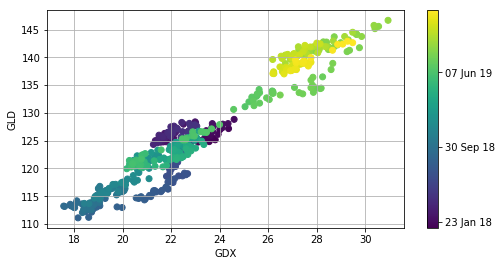

In [10]:
plt.figure(figsize=(8,4))
plt.scatter(data['GDX'], data['GLD'], c=mpl_dates, marker='o')
plt.grid(True)
plt.xlabel('GDX')
plt.ylabel('GLD')
plt.colorbar(ticks=mpl.dates.DayLocator(interval=250),
            format=mpl.dates.DateFormatter('%d %b %y'))

In [ ]:
with pm.Model() as model:
    # 사전 확률 정의
    alpha = pm.Normal('alpha',mu=0,sd=20)
    beta = pm.Normal('beta',mu=0,sd=20)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    
    # 선형 회귀선 정의
    y_est = alpha + beta*data['GDX'].values
    
    # 우도 정의
    likelihood = pm.Normal('GLD', mu=y_est, sd=sigma, observed=data['GLD'].values)
    
    # 추정 과정
    start = pm.find_MAP() # 최적화를 사용하여 시작값 추정
    step = pm.NUTS() # MCMC 샘플링 알고리즘 인스턴스 생성 NUTS는 스테이트 자동 설정
    trace = pm.sample(100, step, start=start, progressbar = False) # NUTS 샘플링을 사용한 100개의 사후 샘플 생성

logp = -1,166.3, ||grad|| = 38.425: 100%|██████████████████████████████████████████████| 56/56 [00:03<00:00, 15.45it/s]
Only 100 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


In [ ]:
fig = pm.traceplot(trace, lines={'alpha':4 , 'beta':2, 'sigma':2})
plt.figure(figsize=(8,8))

In [ ]:
plt.figure(figsize=(8,4))
plt.scatter(data['GDX'], data['GLD'], c=mpl_dates, marker='o')
plt.grid(True)
plt.xlabel('GDX')
plt.ylabel('GLD')
for i in range(len(trace)):
    plt.plot(data['GDX'], trace['alpha'][i] + trace['beta'][i] * data['GDX'])
plt.colorbar(ticks=mpl.dates.DayLocator(interval=250),
            format=mpl.dates.DateFormatter('%d %b %y'))

베이즈 방법은 일반적으로 통시적이다. 즉, 시간이 지나면서 새로운 자료가 추가되고 회귀 및 추정 결과가 개선된다.  
이 예제에 이러한 개념을 적용하려면 회귀 모수가 고정 확률 분포가 아니라 시간에 따라 변화하는 일종의 랜덤 워크 형태이어야 한다. 금융공학 이론에서 확률 변수로부터 확률과정(확률 변수의 순열)으로 바뀌는 과정과 같은 형태의 일반화이달.  
새로운 PyMC3 모형을 정의한다. 이번에는 모수를 랜덤워크로 설정한다. 그 분산값은 (샘플링 특성 개선을 위해) 로그 공간으로 변환하여 사용한다.

In [19]:
model_randomwalk = pm.Model()
with model_randomwalk:
    sigma_alpha = pm.Exponential('sigma_alpha',1./.02, testval=.1)
    sigma_beta = pm.Exponential('sigma_beta', 1./.02, testval=.1)

In [20]:
from pymc3.distributions.timeseries import GaussianRandomWalk

In [21]:
subsample_alpha = 50
subsample_beta = 50

In [24]:
with model_randomwalk:
    alpha = GaussianRandomWalk('alpha', sigma_alpha**-2, shape= int(len(data)/subsample_alpha))
    beta = GaussianRandomWalk('beta', sigma_beta**-2, shape= int(len(data)/subsample_beta))
    # 계수 자료의 길이를 가격 자료와 같게 만든다.
    alpha_r = np.repeat(alpha, subsample_alpha)
    beta_r = np.repeat(beta, subsample_beta)

In [25]:
len(data.dropna().GDX.values)

503

In [26]:
# 50개씩 나누어 적용하기 위해 전체 자료 중 앞 부분의 500개 자료만 회귀분석에 사용한다.
with model_randomwalk:
    # 회귀식 정의
    regression = alpha_r + beta_r*data.GDX.values[:500]
    
    #가격이 정규분포라고 가정한다.
    #평균은 regression에서 구한다.
    sd = pm.Uniform('sd', 0, 20)
    likeligood = pm.Normal('GLD', mu=regression, sd=sd, observed=data.GLD.values[:500])

In [27]:
import scipy.optimize as sco

In [ ]:
with model_randomwalk:
    # 추정 과정
    start = pm.find_MAP(vars=[alpha, beta], fmin=sco.fmin_l_bfgs_b) # 최적화를 사용하여 시작값 추정
    step = pm.NUTS() # MCMC 샘플링 알고리즘 인스턴스 생성 NUTS는 스테이트 자동 설정
    trace_rw = pm.sample(100, step, start=start, progressbar = False) # NUTS 샘플링을 사용한 100개의 사후 샘플 생성

In [ ]:
np.shape(trace_rw['alpha'])

In [ ]:
part_dates = np.linspace(min(mpl_dates),max(mpl_dates), 39)

In [ ]:
fig, ax1 = plt.subplots(figsize=(10,5))
plt.plot(part_dates, np.mean(trace_rw['alpha'], axis=0),
        'b', lw=2.5, label='alpha')
for i in range(45,55):
    plt.plot(part_dates, trace_rw['alpha'][i], 'b-.', lw=0.75)
plt.xlabel('date')
plt.ylabel('alpha')
plt.grid(True)
plt.legend(loc=2)
ax1.xaxis.set_major_formatter(mpl.daes.DateFormatter('%d %b %y'))
ax2 = ax1.twinx()
plt.plot(part_dates, trace_rw['beta'][i], 'r-.', lw=0.75)
plt.ylabel('beta')
plt.legend(loc=4)
fig.autofmt_xdate()

In [ ]:
plt.figure(figsize=(10,5))
plt.scatter(data['GDX'], data['GLD'], c=mpl_dates, marker='o')
plt.colorbar(ticks=mpl.dates.DayLocator(interval=250),
            format=mpl.dates.DateFormatter('%d %b %y'))
plt.grid(True)
plt.xlabel('GDX')
plt.ylabel('GLD')
x = np.linspace(min(data['GDX']), max(data['GDX']))
for i in range(39):
    alpha_rw = np.mean(trace_rw['alpha'].T[i])
    beta_rw = np.mean(trace_rw['beta'].T[i])
    plt.plot(x, alpha_rw + beta_rw*x, color=plt.cm.jet(256*i /39))
